In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from voting_mechanism_design.agents.pairwise_badgeholder import PairwiseBadgeholder, PairwiseBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.pairwise_binary import PairwiseBinary
from voting_mechanism_design.sim import RoundSimulation

import itertools
import numpy as np
import pandas as pd
import choix
import math

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats

from tqdm.auto import tqdm
from joblib import Parallel, delayed


In [3]:
# a metric used for comparing the inferred ranking to the actual ranking
def min_swaps_to_sort(arr1, arr2):
    n = len(arr1)
    # Create a map of value to its index in arr1
    index_map = {value: i for i, value in enumerate(arr1)}

    visited = [False] * n
    swaps = 0

    for i in range(n):
        if visited[i] or arr1[i] == arr2[i]:
            continue

        cycle_size = 0
        x = i

        while not visited[x]:
            visited[x] = True
            x = index_map[arr2[x]]
            cycle_size += 1

        if cycle_size > 0:
            swaps += (cycle_size - 1)

    return swaps

def run_single_simulation(
        n_badgeholders=50, 
        badgeholder_expertise_distribution=None,  # a vector input that should be len==#badgeholders
        badgeholder_voting_style='skewed_towards_impact',
        badgeholder_laziness_distribution=None,   # a vector input that should be len==#badgeholders
        n_projects=20, 
        project_impact_distribution=None,         # a vector input that should be len==#projects
        badgeholder_coi_mappings=None,  # a dictionary of badgeholder_id to project_id that is COI
        coi_factor=1.0,
        random_seed=1234
    ):
    assert badgeholder_expertise_distribution is not None
    assert badgeholder_laziness_distribution is not None
    assert project_impact_distribution is not None
    assert len(badgeholder_expertise_distribution) == n_badgeholders, f'{len(badgeholder_expertise_distribution)} != {n_badgeholders}'
    assert len(badgeholder_laziness_distribution) == n_badgeholders, f'{len(badgeholder_laziness_distribution)} != {n_badgeholders}'
    assert len(project_impact_distribution) == n_projects, f'{len(project_impact_distribution)} != {n_projects}'

    rng = np.random.default_rng(random_seed)

    if badgeholder_coi_mappings is None:
        badgeholder_coi_mappings = {}
    # this loop error checking assumes that badgeholderIds and projectIds are 0-indexed
    for badgeholder_id, project_ids in badgeholder_coi_mappings.items():
        if badgeholder_id >= n_badgeholders:
            raise ValueError('COI badgeholder_id must be less than n_badgeholders')
        for project_id in project_ids:
            if project_id >= n_projects:
                raise ValueError('COI project_id must be less than n_projects')
    
    # get a list of all the projects that will be voted via COI
    coi_projects_list = []
    for badgeholder_id, project_ids in badgeholder_coi_mappings.items():
        coi_projects_list.extend(project_ids)

    # create badgeholders
    badgeholder_list = []
    for ii in range(n_badgeholders):
        badgeholder_id = ii
        expertise = badgeholder_expertise_distribution[ii]
        laziness = badgeholder_laziness_distribution[ii]
        
        if badgeholder_id in badgeholder_coi_mappings:
            coi_project_ids = badgeholder_coi_mappings[badgeholder_id]
            coi_factor_i = coi_factor
            # print(f'Badgeholder {badgeholder_id} is engaging in COI with projects: {coi_project_ids}')
        else:
            coi_project_ids = []
            coi_factor_i = 0
        agent = PairwiseBadgeholder(
            badgeholder_id=badgeholder_id,
            voting_style=badgeholder_voting_style,
            voting_style_kwargs={'use_impact_delta':False},
            expertise=expertise,
            laziness=laziness,
            coi_project_ix_vec=coi_project_ids,
            coi_factor=coi_factor_i,
        )
        badgeholder_list.append(agent)
    badgeholders = PairwiseBadgeholderPopulation()
    badgeholders.add_badgeholders(badgeholder_list)

    # create projects
    projects = []
    for ii in range(n_projects):
        project_id = ii
        project_impact = project_impact_distribution[ii]
        project = Project(
            project_id=project_id,
            true_impact=project_impact,  
            owner_id=None,  # used for COI modeling
        )
        projects.append(project)
    project_population = ProjectPopulation()
    project_population.add_projects(projects)

    # this is a no-op currently, but can change in the future
    fund_distribution_model = PairwiseBinary()

    # create and run a simulation
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
        random_seed=random_seed
    )

    # voters can vote on all projects, but an individual badgeholder can decide to ignore
    # some, based on the badgeholder configuration
    voting_view_ix = list(itertools.combinations(range(project_population.num_projects), 2))  # we need a list since we use this twice
    voting_view = []
    for ix1, ix2 in voting_view_ix:
        voting_view.append((project_population.get_project(ix1), project_population.get_project(ix2)))
    simulation_obj.run(cast_votes_kwargs={'view': voting_view})

    # store the project impact differences
    impact_diff_vec = []
    for ix1, ix2 in voting_view_ix:
        p1 = project_population.get_project(ix1)
        p2 = project_population.get_project(ix2)
        impact_diff_vec.append(p1.true_impact - p2.true_impact)

    # make a matrix of all the pairwise voting possibilities
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    project_list = simulation_obj.projects.projects
    N = len(project_list)
    project_vote_matrix = np.zeros((N, N))
    project2ix = {p:ix for ix, p in enumerate(project_list)}
    vote_data_list = []

    # put the votes into the matrix for analysis
    for v in all_votes:
        ix1 = project2ix[v.project1]
        ix2 = project2ix[v.project2]
        project_vote_matrix[ix1, ix2] += v.val1
        project_vote_matrix[ix2, ix1] += v.val2

        if v.val1 > v.val2:
            vote_data_list.append((ix1, ix2))
        elif v.val2 > v.val1:
            vote_data_list.append((ix2, ix1))
        else:
            # TODO: not sure if there is a tie, is that even possible??
            print('In Tie scenario!')
            pass

    # estimate parameters of bradley terry model - TODO: update to MCMC estimation
    try:
        params = choix.ilsr_pairwise(N, vote_data_list)  
    except ValueError:
        params = choix.ilsr_pairwise(N, vote_data_list, alpha=0.01)
    # create rank order of project ids
    project_ix_worst_to_best_inferred = np.argsort(params)
    project_ix_best_to_worst_inferred = project_ix_worst_to_best_inferred[::-1]

    # compare the inferred ranks to the actual ranks
    actual_project_impacts = np.array([p.true_impact for p in project_list])
    # rank them
    project_ix_worst_to_best_actual = np.argsort(actual_project_impacts)
    project_ix_best_to_worst_actual = project_ix_worst_to_best_actual[::-1]

    # # compare the two
    # print('Actual Project Ranking by impact:', project_ix_worst_to_best_actual)
    # print('Inferred Project Ranking by impact:', project_ix_worst_to_best_inferred)

    min_swaps = min_swaps_to_sort(project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred)
    tau = stats.kendalltau(project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred).correlation

    return min_swaps, tau, impact_diff_vec, project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred

def run_n_simulations(
    n_sims,
    n_badgeholders, 
    badgeholder_expertise_distribution,
    badgeholder_voting_style,
    badgeholder_laziness_distribution,
    n_projects, 
    project_impact_distribution,
    badgeholder_coi_mappings,
    coi_factor=1.0,
    random_seed_start=1234,
    n_jobs=-1  # Number of parallel jobs (-1 means using all processors)
):
    def run_simulation(ii):
        seed = random_seed_start + ii
        min_swaps, ktau, impact_diff_vec, project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred = run_single_simulation(
            n_badgeholders=n_badgeholders, 
            badgeholder_expertise_distribution=badgeholder_expertise_distribution,
            badgeholder_voting_style=badgeholder_voting_style,
            badgeholder_laziness_distribution=badgeholder_laziness_distribution,
            n_projects=n_projects, 
            project_impact_distribution=project_impact_distribution,
            badgeholder_coi_mappings=badgeholder_coi_mappings,
            coi_factor=coi_factor,
            random_seed=seed
        )
        return min_swaps, ktau, impact_diff_vec, project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred

    results = Parallel(n_jobs=n_jobs)(delayed(run_simulation)(ii) for ii in tqdm(range(n_sims), disable=True))
    # results = []
    # for ii in tqdm(range(n_sims), disable=True):
    #     results.append(run_simulation(ii))
    
    min_swaps_list, ktau_list, impact_diff_vec, project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred = zip(*results)
    min_swaps_list = np.array(min_swaps_list)
    ktau_list = np.array(ktau_list)
    impact_diff_vec = np.array(impact_diff_vec)
    project_ix_worst_to_best_actual = np.array(project_ix_worst_to_best_actual)
    project_ix_worst_to_best_inferred = np.array(project_ix_worst_to_best_inferred)

    return {
        'min_swaps_list': min_swaps_list,
        'ktau_list': ktau_list,
        'impact_diff_vec': impact_diff_vec,
        'project_ix_worst_to_best_actual': project_ix_worst_to_best_actual,
        'project_ix_worst_to_best_inferred': project_ix_worst_to_best_inferred
    }

In [4]:
def run_mc_coiindex(
    num_mc = 32,
    n_badgeholders = 30,
    n_projects = 100,
    badgeholder_voting_style = 'skewed_towards_impact',
    coi_project_ix = 25,
    coi_badgeholder_ix = 0,
    coi_factor=1.0,

    # set these directly so we can more directly measure the impact of COI
    project_impact_distribution=None,
    badgeholder_expertise_distribution=None,
    badgeholder_laziness_distribution=None,

    seed_start=1234,
):
    if project_impact_distribution is None:
        raise ValueError("project_impact_distribution must be set")
    if badgeholder_expertise_distribution is None:
        raise ValueError("badgeholder_expertise_distribution must be set")
    if badgeholder_laziness_distribution is None:
        raise ValueError("badgeholder_laziness_distribution must be set")
    badgeholder_coi_mapping = {
        coi_badgeholder_ix: [coi_project_ix],
    }

    sim_results_with_coi = run_n_simulations(
        num_mc,
        n_badgeholders=n_badgeholders, 
        badgeholder_expertise_distribution=badgeholder_expertise_distribution,
        badgeholder_voting_style=badgeholder_voting_style,
        badgeholder_laziness_distribution=badgeholder_laziness_distribution,
        n_projects=n_projects, 
        project_impact_distribution=project_impact_distribution,
        badgeholder_coi_mappings=badgeholder_coi_mapping,
        coi_factor=coi_factor,
        random_seed_start=seed_start,
        n_jobs=-1
    )
    sim_results_without_coi = run_n_simulations(
        num_mc,
        n_badgeholders=n_badgeholders, 
        badgeholder_expertise_distribution=badgeholder_expertise_distribution,
        badgeholder_voting_style=badgeholder_voting_style,
        badgeholder_laziness_distribution=badgeholder_laziness_distribution,
        n_projects=n_projects, 
        project_impact_distribution=project_impact_distribution,
        badgeholder_coi_mappings=None,
        coi_factor=0.0,
        random_seed_start=seed_start,  # same seed to make results directly comparable
        n_jobs=-1
    )

    actual_minus_inferred_with_coi_allprojects = sim_results_with_coi['project_ix_worst_to_best_actual'] - sim_results_with_coi['project_ix_worst_to_best_inferred']
    actual_minus_inferred_without_coi_allprojects = sim_results_without_coi['project_ix_worst_to_best_actual'] - sim_results_without_coi['project_ix_worst_to_best_inferred']

    # coi_project_ixx = np.where(sim_results_with_coi['project_ix_worst_to_best_actual'] == coi_project_ix)
    # print(coi_project_ix)
    # print(sim_results_with_coi['project_ix_worst_to_best_actual'])
    # print(coi_project_ixx)

    coi_project_inferred_ix_with_coi = np.where(sim_results_with_coi['project_ix_worst_to_best_inferred'] == coi_project_ix)
    coi_project_inferred_ix_without_coi = np.where(sim_results_without_coi['project_ix_worst_to_best_inferred'] == coi_project_ix)

    
    return {
        'sim_results_with_coi': sim_results_with_coi,
        'sim_results_without_coi': sim_results_without_coi,
        'actual_minus_inferred_with_coi_allprojects': actual_minus_inferred_with_coi_allprojects,
        'actual_minus_inferred_without_coi_allprojects': actual_minus_inferred_without_coi_allprojects,
        'coi_project_ix': coi_project_ix,
        'coi_project_inferred_ix_with_coi': coi_project_inferred_ix_with_coi,
        'coi_project_inferred_ix_without_coi': coi_project_inferred_ix_without_coi
    }

In [5]:
num_mc = 32
n_badgeholders = 30
n_projects = 100
badgeholder_voting_style = 'skewed_towards_impact'

project_impact_distribution = np.linspace(0.1, 0.9, n_projects)
badgeholder_expertise_vec = [0.25, 0.5, 0.75]
badgeholder_laziness_vec = [0.25, 0.5, 0.75]

coi_index = [0, 25, 50, 75, 99]
# coi_factor = 1.0
coi_factor_vec = [0.5, 0.75, 1.0]
experiment_cfgs = list(itertools.product(
    coi_index,
    coi_factor_vec,
    badgeholder_expertise_vec,
    badgeholder_laziness_vec,
))


exp2results = {}
for experiment_cfg in tqdm(experiment_cfgs):
    # print(f'Running COI index: {coi_ix}')
    coi_ix, coi_factor, expertise, laziness = experiment_cfg
    badgeholder_expertise_distribution = np.ones(n_badgeholders) * expertise
    badgeholder_laziness_distribution = np.ones(n_badgeholders) * laziness
    res = run_mc_coiindex(
        num_mc = num_mc,
        n_badgeholders = n_badgeholders,
        n_projects = n_projects,
        badgeholder_voting_style = badgeholder_voting_style,
        coi_project_ix = coi_ix,
        coi_badgeholder_ix=0,  # TOOD: may want to sweep this, in case we are varying expertise
        coi_factor=coi_factor,

        # set these directly so we can more directly measure the impact of COI
        project_impact_distribution=project_impact_distribution,
        badgeholder_expertise_distribution=badgeholder_expertise_distribution,
        badgeholder_laziness_distribution=badgeholder_laziness_distribution,

        seed_start=1234,
    )
    exp2results[experiment_cfg] = res

  0%|          | 0/135 [00:00<?, ?it/s]

In [19]:
# make into a melted df
results_list = []
for experiment_cfg in experiment_cfgs: 
    coi_ix, coi_factor, expertise, laziness = experiment_cfg
    coi_project_inferred_ix_without_coi = np.asarray(exp2results[experiment_cfg]['coi_project_inferred_ix_without_coi'][1])
    coi_project_inferred_ix_with_coi = np.asarray(exp2results[experiment_cfg]['coi_project_inferred_ix_with_coi'][1])

    delta = coi_project_inferred_ix_with_coi - coi_project_inferred_ix_without_coi
    
    for d in delta:
        results_list.append({
            'coi_ix': coi_ix,
            'coi_factor': coi_factor,
            'expertise': expertise,
            'laziness': laziness,
            'delta': d,
            'hue': '%0.02f/%0.02f' % (expertise, laziness)
        })
df = pd.DataFrame(results_list)

/tmp/ipykernel_81871/2431363348.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Least Impactful Project', '', '', '', 'Most Impactful Project'])


Text(0.5, 1.0, 'COI Factor: 0.5')

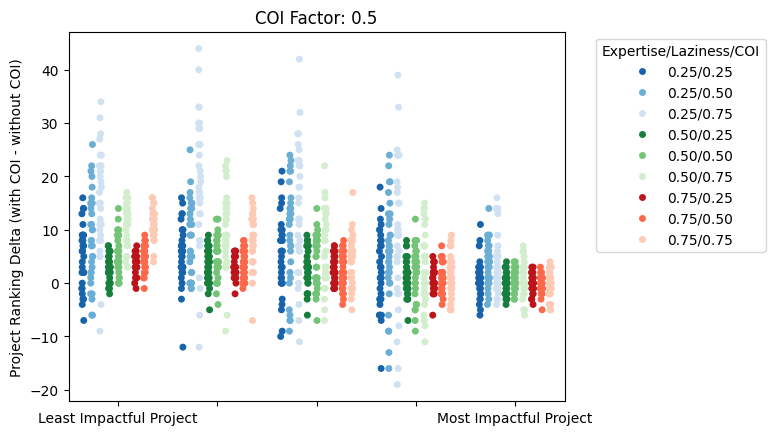

In [20]:
# setup the color pallete
color_range = np.linspace(0.2, 0.8, len(badgeholder_laziness_vec))
colors=['Blues', 'Greens', 'Reds', 'Purples']
palette = {}
coi_factor = 0.5 # TODO: put this into a sweep
for jj, m in enumerate(badgeholder_expertise_vec):
    color = mpl.colormaps[colors[jj]]
    for ii, l in enumerate(badgeholder_laziness_vec):
        key='%0.02f/%0.02f' % (m, l)
        palette[key] = color(color_range[len(badgeholder_laziness_vec)-ii-1])

dff = df[df['coi_factor']==coi_factor]
ax = sns.stripplot(data=dff, x='coi_ix', y='delta', hue='hue', 
                   dodge=True, palette=palette, zorder=1,)  # TODO: custom legend
plt.ylabel('Project Ranking Delta (with COI - without COI)')
ax.set_xticklabels(['Least Impactful Project', '', '', '', 'Most Impactful Project'])
ax.set_xlabel('')
ax.legend(title='Expertise/Laziness/COI', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title(f'COI Factor: {coi_factor}')

In [8]:
# TODO: make a plot of how the overall project ranking is updated by COI

# # this is for the whole population
# actual_minus_inferred_with_coi = sim_results_with_coi['project_ix_worst_to_best_actual'] - sim_results_with_coi['project_ix_worst_to_best_inferred']
# actual_minus_inferred_without_coi = sim_results_without_coi['project_ix_worst_to_best_actual'] - sim_results_without_coi['project_ix_worst_to_best_inferred']

# # actual_minus_inferred_with_coi
# fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# sns.histplot(actual_minus_inferred_with_coi.flatten(), ax=ax, label='With COI')
# sns.histplot(actual_minus_inferred_without_coi.flatten(), ax=ax, label='Without COI')
# ax.set_title('Actual - Inferred Project Ranking')
# ax.legend()